In [1]:
#import the reqired libraries
import shutil
import csv
import codecs
import os
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from fastapi import FastAPI as FP
from fastapi import HTTPException, Depends, Security
from fastapi.security.api_key import APIKeyQuery, APIKeyCookie, APIKeyHeader, APIKey
from starlette.status import HTTP_403_FORBIDDEN
from starlette.responses import RedirectResponse, JSONResponse
from dotenv import load_dotenv, find_dotenv
import uvicorn
from fastapi import FastAPI, File, UploadFile
import warnings; warnings.simplefilter('ignore')

In [2]:
app = FP()
load_dotenv(find_dotenv())

API_KEY = os.environ.get("token")
API_KEY_NAME = "access_token"
api_key_query = APIKeyQuery(name=API_KEY_NAME, auto_error=False)
api_key_header = APIKeyHeader(name=API_KEY_NAME, auto_error=False)

In [3]:
async def get_api_key(
    api_key_query: str = Security(api_key_query),
    api_key_header: str = Security(api_key_header),
):
    if api_key_query == API_KEY:
        return api_key_query
    elif api_key_header == API_KEY:
        return api_key_header
    else:
        raise HTTPException(
            status_code=HTTP_403_FORBIDDEN, detail="Could not validate credentials"
        )

In [4]:
# Import the dataset and give the column names
columns=['customer_id', 'product_id', 'sku_id','quantity']
order_df=pd.read_csv('data/toysplanet.csv',names=columns)
# catalog_df=pd.read_csv('data/traficcatalogue.csv')
# order_df=pd.merge(order_df, catalog_df, on='sku_id', how='inner')
order_df=order_df[['customer_id','sku_id','quantity']]

In [5]:
order_df.head()


,customer_id,sku_id,quantity
0,33,HOT903752,1.0
1,85,NECA55062,1.0
2,62,DIAMOCT192537,1.0
3,40,HASE8163,1.0
4,131,HASE9634,1.0


In [6]:
order_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539 entries, 0 to 538
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  539 non-null    int64  
 1   sku_id       539 non-null    object 
 2   quantity     539 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 12.8+ KB


In [7]:
rows,columns=order_df.shape
print('Number of rows: ',rows)
print('Number of columns: ',columns)

Number of rows:  539
Number of columns:  3


In [8]:
order_df.dtypes

customer_id      int64
sku_id          object
quantity       float64
dtype: object

In [9]:
order_df1=order_df.iloc[:50000,0:]

In [10]:
order_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539 entries, 0 to 538
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  539 non-null    int64  
 1   sku_id       539 non-null    object 
 2   quantity     539 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 12.8+ KB


In [11]:
order_df1['quantity'].describe().transpose()

count    539.000000
mean       1.014842
std        0.135524
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        3.000000
Name: quantity, dtype: float64

In [12]:
print('Number of missing values across columns: \n',order_df.isnull().sum())

Number of missing values across columns: 
 customer_id    0
sku_id         0
quantity       0
dtype: int64


## Ratings

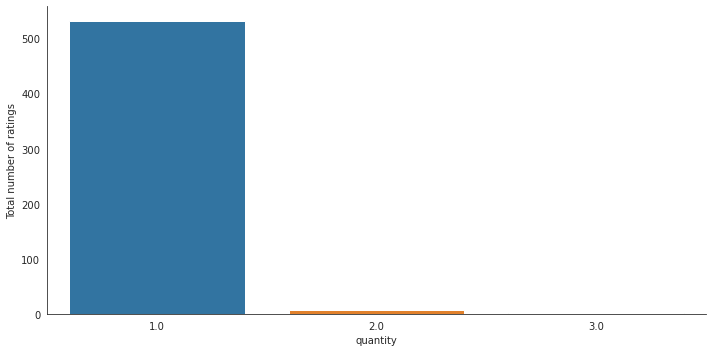

In [13]:
with sns.axes_style('white'):
    g = sns.factorplot("quantity", data=order_df1, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings") 

## Users and products

In [14]:
print('Number of unique users in Raw data = ', order_df1['customer_id'].nunique())
print('Number of unique product in Raw data = ', order_df1['sku_id'].nunique())

Number of unique users in Raw data =  246
Number of unique product in Raw data =  504


In [15]:
#Check the top 10 users based on ratings
most_rated=order_df1.groupby('customer_id').size().sort_values(ascending=False)
print(most_rated)

customer_id
741     25
205     14
913     13
290     12
243     12
        ..
1081     1
1094     1
1101     1
1131     1
888      1
Length: 246, dtype: int64


In [16]:
counts=order_df1.customer_id.value_counts()
order_df1_final=order_df1[order_df1.customer_id.isin(counts[counts>=1].index)]
print('Number of users who have rated 25 or more items =', len(order_df1_final))
print('Number of unique users in the final data = ', order_df1_final['customer_id'].nunique())
print('Number of unique products in the final data = ', order_df1_final['customer_id'].nunique())

Number of users who have rated 25 or more items = 539
Number of unique users in the final data =  246
Number of unique products in the final data =  246


In [17]:
final_ratings_matrix = order_df1_final.pivot_table(index = 'customer_id', columns ='sku_id', values = 'quantity').fillna(0)
final_ratings_matrix.head()

sku_id,13 : 4549660641018,13665361046513,147941,185647,198480-1,203091,203831,204878-1,206145,206792,...,WRC13620,WRC13620-1,WRC15821,YU-GI-OH! JCC – Pack Duellistes Legendaires Saison 3 FR,YUME12903,batmanXM16,capHot,gargNecthai,hawkmaxm-1,kotofri13-1
customer_id,,,,,,,,,,,,,,,,,,,,,
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [18]:
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

Shape of final_ratings_matrix:  (246, 504)


In [19]:
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

given_num_of_ratings =  539
possible_num_of_ratings =  123984
density: 0.43%


In [20]:
train_data, test_data = train_test_split(order_df1_final, test_size = 0.3, random_state=0)
train_data.head()

,customer_id,sku_id,quantity
124,441,WET075003203,1.0
154,446,BOG03FE,1.0
438,1771,BTN62134-4,1.0
59,437,UCU1380-1,1.0
233,438,BTN61443-8,1.0


In [21]:
print('Shape of training data: ',train_data.shape)
print('Shape of testing data: ',test_data.shape)

Shape of training data:  (377, 3)
Shape of testing data:  (162, 3)


In [22]:
train_data_grouped = train_data.groupby('sku_id').agg({'customer_id': 'count'}).reset_index()
train_data_grouped.rename(columns = {'customer_id': 'score'},inplace=True)
train_data_grouped.head(40)

,sku_id,score
0,13 : 4549660641018,1
1,13665361046513,1
2,198480-1,1
3,203091,1
4,203831,1
5,206145,1
6,206792,1
7,3Z0195-1,1
8,3Z0196-1,1
9,3Z0197-1-1,1


In [23]:
train_data_sort = train_data_grouped.sort_values(['score', 'sku_id'], ascending = [0,1]) 
train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
popularity_recommendations = train_data_sort.head(10) 
popularity_recommendations 

,sku_id,score,rank
147,HASF0493-1,3,1.0
224,MCF15076-1,3,2.0
22,9791026813873,2,3.0
24,9791026824107,2,4.0
46,BOG03FE,2,5.0
56,BoglinsGold HornedDroll,2,6.0
65,DHHALO,2,7.0
77,DOCO-95129,2,8.0
151,HASF1269-1-1-1-1,2,9.0
157,HASF3858-1,2,10.0


In [24]:
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
    user_recommendations['customer_id'] = user_id 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [25]:
find_recom = [1, 5]
for i in find_recom:
    print("The list of recommendations for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

The list of recommendations for the userId: 1

     customer_id                   sku_id  score  rank
147            1               HASF0493-1      3   1.0
224            1               MCF15076-1      3   2.0
22             1            9791026813873      2   3.0
24             1            9791026824107      2   4.0
46             1                  BOG03FE      2   5.0
56             1  BoglinsGold HornedDroll      2   6.0
65             1                   DHHALO      2   7.0
77             1               DOCO-95129      2   8.0
151            1         HASF1269-1-1-1-1      2   9.0
157            1               HASF3858-1      2  10.0


The list of recommendations for the userId: 5

     customer_id                   sku_id  score  rank
147            5               HASF0493-1      3   1.0
224            5               MCF15076-1      3   2.0
22             5            9791026813873      2   3.0
24             5            9791026824107      2   4.0
46             5        

In [26]:
order_df_CF = pd.concat([train_data, test_data]).reset_index()
order_df_CF.head()

,index,customer_id,sku_id,quantity
0,124,441,WET075003203,1.0
1,154,446,BOG03FE,1.0
2,438,1771,BTN62134-4,1.0
3,59,437,UCU1380-1,1.0
4,233,438,BTN61443-8,1.0


In [27]:
pivot_df = order_df_CF.pivot_table(index = 'customer_id', columns ='sku_id', values = 'quantity').fillna(0)
pivot_df.head()

sku_id,13 : 4549660641018,13665361046513,147941,185647,198480-1,203091,203831,204878-1,206145,206792,...,WRC13620,WRC13620-1,WRC15821,YU-GI-OH! JCC – Pack Duellistes Legendaires Saison 3 FR,YUME12903,batmanXM16,capHot,gargNecthai,hawkmaxm-1,kotofri13-1
customer_id,,,,,,,,,,,,,,,,,,,,,
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [28]:
print('Shape of the pivot table: ', pivot_df.shape)

Shape of the pivot table:  (246, 504)


In [29]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

sku_id,13 : 4549660641018,13665361046513,147941,185647,198480-1,203091,203831,204878-1,206145,206792,...,WRC13620-1,WRC15821,YU-GI-OH! JCC – Pack Duellistes Legendaires Saison 3 FR,YUME12903,batmanXM16,capHot,gargNecthai,hawkmaxm-1,kotofri13-1,user_index
customer_id,,,,,,,,,,,,,,,,,,,,,
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4


* As this is a sparse matrix we will use SVD.

In [30]:
U, sigma, Vt = svds(pivot_df, k = 75)

In [31]:
print('Left singular matrix: \n',U)

Left singular matrix: 
 [[ 1.38777878e-17 -1.36609474e-17  3.46944695e-18 ...  1.08862304e-13
  -3.53380238e-14  1.93429680e-18]
 [ 1.35525272e-19 -1.08420217e-19  2.03287907e-19 ... -3.86579401e-06
   2.19644891e-05 -4.50281597e-04]
 [-1.38777878e-17 -1.82145965e-17  0.00000000e+00 ... -2.10834894e-03
   3.98561539e-04 -9.00574607e-04]
 ...
 [ 9.64917819e-03 -2.20898679e-01  1.00458511e-01 ... -1.01767781e-03
   5.56690583e-03 -1.09418450e-01]
 [-2.77555756e-17  0.00000000e+00  0.00000000e+00 ... -1.36253147e-03
   6.41781406e-03 -1.09868799e-01]
 [ 4.16333634e-17  1.38777878e-17  2.08166817e-17 ... -1.09834475e-03
   5.79688011e-03 -1.10319029e-01]]


In [32]:
print('Sigma: \n',sigma)

Sigma: 
 [1.41421356e+00 1.41421356e+00 1.41421356e+00 1.41421356e+00
 1.41421356e+00 1.41421356e+00 1.41421356e+00 1.41421356e+00
 1.41421356e+00 1.41421356e+00 1.41421356e+00 1.41421356e+00
 1.41421356e+00 1.54320771e+00 1.61479710e+00 1.61803399e+00
 1.61803399e+00 1.61803399e+00 1.66069823e+00 1.69914295e+00
 1.71430795e+00 1.73205081e+00 1.73205081e+00 1.73205081e+00
 1.73205081e+00 1.73205081e+00 1.73205081e+00 1.73205081e+00
 1.73205081e+00 1.73205081e+00 1.73205081e+00 1.73205081e+00
 1.88345835e+00 1.90211303e+00 1.92819181e+00 1.94475515e+00
 1.97942540e+00 2.00000000e+00 2.00000000e+00 2.00000000e+00
 2.00000000e+00 2.00000000e+00 2.00000000e+00 2.00000000e+00
 2.00000000e+00 2.00000000e+00 2.07358727e+00 2.13165054e+00
 2.14853789e+00 2.19161117e+00 2.21435355e+00 2.23606798e+00
 2.23606798e+00 2.23606798e+00 2.43051170e+00 2.44948974e+00
 2.44948974e+00 2.44948974e+00 2.55690478e+00 2.59339593e+00
 2.64515434e+00 2.65007342e+00 2.82817275e+00 2.83192578e+00
 2.99881027e+00

In [33]:
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [[1.41421356e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.41421356e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.41421356e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.74150292e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  5.02523367e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 2.22083249e+03]]


In [34]:
print('Right singular matrix: \n',Vt)

Right singular matrix: 
 [[ 1.47196168e-17  1.47196168e-17  0.00000000e+00 ...  9.81307787e-18
   9.81307787e-18  2.86787201e-15]
 [-9.81307787e-18 -9.81307787e-18  0.00000000e+00 ...  0.00000000e+00
  -1.96261557e-17  1.29238236e-14]
 [ 0.00000000e+00  0.00000000e+00 -9.81307787e-18 ...  7.35980840e-18
   4.90653893e-18 -2.55090959e-14]
 ...
 [-3.62025709e-04 -3.62025709e-04 -3.40852248e-04 ... -1.78746984e-04
  -2.04577474e-04 -1.34306600e-05]
 [ 4.42511127e-04  4.42511127e-04  1.11770723e-03 ...  7.56155208e-04
   8.65426192e-04  1.06005851e-04]
 [-1.41927665e-05 -1.41927665e-05 -4.11590055e-05 ... -3.50763583e-05
  -4.01451962e-05 -9.99999800e-01]]


In [35]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
preds_df = pd.DataFrame(all_user_predicted_ratings,index=pivot_df.index, columns = pivot_df.columns)
preds_df.head()

sku_id,13 : 4549660641018,13665361046513,147941,185647,198480-1,203091,203831,204878-1,206145,206792,...,WRC13620-1,WRC15821,YU-GI-OH! JCC – Pack Duellistes Legendaires Saison 3 FR,YUME12903,batmanXM16,capHot,gargNecthai,hawkmaxm-1,kotofri13-1,user_index
customer_id,,,,,,,,,,,,,,,,,,,,,
11,5.395681e-16,5.395681e-16,6.182001e-15,4.502418e-15,6.182001e-15,1.226893e-13,5.433867e-14,8.730711e-14,5.108469e-15,6.182001e-15,...,4.485438e-13,8.730711e-14,1.127183e-15,5.108469e-15,2.291135e-13,-2.236071e-13,1.992584e-13,-2.261826e-13,-3.510484e-13,-7.833896e-14
30,1.261063e-06,1.261063e-06,3.186038e-06,2.319008e-06,3.186038e-06,6.203034e-05,2.754044e-05,4.427061e-05,-1.491658e-07,3.186038e-06,...,2.509231e-05,4.427061e-05,6.056048e-07,-1.491658e-07,5.089477e-05,4.189942e-05,4.852757e-05,4.095254e-05,4.687053e-05,9.999999e-01
33,-1.654897e-04,-1.654897e-04,9.901688e-06,7.114061e-06,9.901688e-06,1.559618e-04,6.924446e-05,1.113089e-04,-3.069564e-07,9.901688e-06,...,5.233570e-05,1.113089e-04,1.931580e-06,-3.069564e-07,1.061526e-04,8.739074e-05,1.012153e-04,8.541581e-05,9.775913e-05,2.000000e+00
40,3.783189e-06,3.783189e-06,9.558114e-06,6.957023e-06,9.558114e-06,1.860910e-04,8.262132e-05,1.328118e-04,-4.474975e-07,9.558114e-06,...,7.527692e-05,1.328118e-04,1.816815e-06,-4.474975e-07,1.526843e-04,1.256983e-04,1.455827e-04,1.228576e-04,1.406116e-04,3.000000e+00
44,-8.291009e-07,-8.291009e-07,-2.186647e-06,-1.583905e-06,-2.186647e-06,-3.931704e-05,-1.745611e-05,-2.806029e-05,9.918585e-01,-2.186647e-06,...,-1.581158e-05,-2.806029e-05,-4.196623e-07,9.918585e-01,-3.207065e-05,-2.640235e-05,-3.057900e-05,-2.580569e-05,-2.953483e-05,4.000000e+00


In [36]:
donnees = {
    
    }

In [66]:
def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    donnees.clear()
    user_idx = userID
    sorted_user_ratings = pivot_df.loc[user_idx].sort_values(ascending=False)
    sorted_user_predictions = preds_df.loc[user_idx].sort_values(ascending=False)
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_popularity', 'user_predictions']
    temp = temp.loc[temp.user_popularity == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    result = temp.to_json(orient="split")
    parsed = json.loads(result)
    # donnees[userID] = []
    # with open(f"Folder/catalog_9-6-2022.json", "r") as read_catalog:
    #     x = json.load(read_catalog)
    #     for y in x:
    #         for i in range(num_recommendations):
    #             if parsed['index'][i] == y["sku"]:
    #                 donnees[userID].append(y["name"])
    # return donnees
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [67]:
userID = 621
num_recommendations = 10
recommend_items(userID, pivot_df, preds_df, num_recommendations)    


Below are the recommended items for user(user_id = 621):

                   user_popularity  user_predictions
Recommended Items                                   
NECA30773-1                    0.0          0.000381
HASF3858-1                     0.0          0.000322
KTOPP936-1                     0.0          0.000320
MEHO716270-1                   0.0          0.000319
LOLPAK-2                       0.0          0.000316
MEHO716270                     0.0          0.000315
DCCFEB200601-1                 0.0          0.000310
TOT-TGUS113-1                  0.0          0.000308
HASF3905                       0.0          0.000303
HASF4366-2                     0.0          0.000302


In [39]:
final_ratings_matrix.head(10)

sku_id,13 : 4549660641018,13665361046513,147941,185647,198480-1,203091,203831,204878-1,206145,206792,...,WRC13620,WRC13620-1,WRC15821,YU-GI-OH! JCC – Pack Duellistes Legendaires Saison 3 FR,YUME12903,batmanXM16,capHot,gargNecthai,hawkmaxm-1,kotofri13-1
customer_id,,,,,,,,,,,,,,,,,,,,,
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
final_ratings_matrix.mean().head()

sku_id
13 : 4549660641018    0.004065
13665361046513        0.004065
147941                0.004065
185647                0.004065
198480-1              0.004065
dtype: float64

In [41]:
preds_df.head()

sku_id,13 : 4549660641018,13665361046513,147941,185647,198480-1,203091,203831,204878-1,206145,206792,...,WRC13620-1,WRC15821,YU-GI-OH! JCC – Pack Duellistes Legendaires Saison 3 FR,YUME12903,batmanXM16,capHot,gargNecthai,hawkmaxm-1,kotofri13-1,user_index
customer_id,,,,,,,,,,,,,,,,,,,,,
11,5.395681e-16,5.395681e-16,6.182001e-15,4.502418e-15,6.182001e-15,1.226893e-13,5.433867e-14,8.730711e-14,5.108469e-15,6.182001e-15,...,4.485438e-13,8.730711e-14,1.127183e-15,5.108469e-15,2.291135e-13,-2.236071e-13,1.992584e-13,-2.261826e-13,-3.510484e-13,-7.833896e-14
30,1.261063e-06,1.261063e-06,3.186038e-06,2.319008e-06,3.186038e-06,6.203034e-05,2.754044e-05,4.427061e-05,-1.491658e-07,3.186038e-06,...,2.509231e-05,4.427061e-05,6.056048e-07,-1.491658e-07,5.089477e-05,4.189942e-05,4.852757e-05,4.095254e-05,4.687053e-05,9.999999e-01
33,-1.654897e-04,-1.654897e-04,9.901688e-06,7.114061e-06,9.901688e-06,1.559618e-04,6.924446e-05,1.113089e-04,-3.069564e-07,9.901688e-06,...,5.233570e-05,1.113089e-04,1.931580e-06,-3.069564e-07,1.061526e-04,8.739074e-05,1.012153e-04,8.541581e-05,9.775913e-05,2.000000e+00
40,3.783189e-06,3.783189e-06,9.558114e-06,6.957023e-06,9.558114e-06,1.860910e-04,8.262132e-05,1.328118e-04,-4.474975e-07,9.558114e-06,...,7.527692e-05,1.328118e-04,1.816815e-06,-4.474975e-07,1.526843e-04,1.256983e-04,1.455827e-04,1.228576e-04,1.406116e-04,3.000000e+00
44,-8.291009e-07,-8.291009e-07,-2.186647e-06,-1.583905e-06,-2.186647e-06,-3.931704e-05,-1.745611e-05,-2.806029e-05,9.918585e-01,-2.186647e-06,...,-1.581158e-05,-2.806029e-05,-4.196623e-07,9.918585e-01,-3.207065e-05,-2.640235e-05,-3.057900e-05,-2.580569e-05,-2.953483e-05,4.000000e+00


In [42]:
preds_df.mean().head()

sku_id
13 : 4549660641018    0.004088
13665361046513        0.004088
147941                0.004056
185647                0.004059
198480-1              0.004056
dtype: float64

In [43]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_popularity', 'Avg_predicted_popularity']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(505, 2)


,Avg_actual_popularity,Avg_predicted_popularity,item_index
sku_id,,,
13 : 4549660641018,0.004065,0.004088,0
13665361046513,0.004065,0.004088,1
147941,0.004065,0.004056,2
185647,0.004065,0.004059,3
198480-1,0.004065,0.004056,4


In [44]:
RMSE = round((((rmse_df.Avg_actual_popularity - rmse_df.Avg_predicted_popularity) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.00115 



In [45]:
@app.get("/token_test")
async def token_validation(api_key: APIKey = Depends(get_api_key)):
    response = "The bot confirm you had a valid Token"
    return {"response": response}

In [46]:
@app.get("/predict")
async def predict_API(user_id:int, num_recommendations:int, call_id:str, api_key: APIKey = Depends(get_api_key)):
    recommend_items(user_id, pivot_df, preds_df, num_recommendations)
    if call_id == "test1" or call_id == "test2":
        return {"response": "Valid",
            "Token": "Valid",
            "call_id": call_id,
            "User" : user_id,
            "Number of recommendations": num_recommendations,
            "data" : donnees,
            }
    else:
        return {"response":"Not valid."}

In [47]:
@app.post("/recup-data")
async def recup_data(file: UploadFile = File(...), api_key: APIKey = Depends(get_api_key)):
    with open(f"Folder/{file.filename}", "wb") as buffer:
        shutil.copyfileobj(file.file, buffer)
    
    with open(f"Folder/{file.filename}", "r") as to_csv:
        df = pd.read_json(to_csv)
        df.to_csv(f"Folder/{file.filename}.csv", index = None)
    
    with open(f"Folder/{file.filename}", "r") as read_data:
        return {"data": json.load(read_data)}
    
    

In [48]:
@app.post("/recup-dataCSV")
async def recup_dataCSV(file: UploadFile = File(...), api_key: APIKey = Depends(get_api_key)):
    csvReader = csv.DictReader(codecs.iterdecode(file.file, 'utf-8'))

    return list(csvReader)

In [49]:
@app.post("/save-dataCSV")
async def save_dataCSV(file: UploadFile = File(...), api_key: APIKey = Depends(get_api_key)):
    csvReader = csv.DictReader(codecs.iterdecode(file.file, 'utf-8'))
    with open(f'Folder/{file.filename}.json', 'w') as file:
        file.write('[')
        for x in csvReader:
            json.dump(x, file)
            file.write(',')
        file.write(']')
    return list(csvReader)

In [50]:
orderTable = {}
@app.get("/order")
async def order(filename:str, api_key: APIKey = Depends(get_api_key)):
    orderTable.clear()
    with open(f"Folder/catalog_{filename}.json", "r") as read_data:
        x = json.load(read_data)
        for y in x:
            name = y["name"]
            orderTable[name] = {
                "reference": y["sku"],
                "categories": y["categories"],
                "created_at": y["created_at"],
                "updated_at": y["updated_at"]
            }
        return {"data": orderTable}

In [51]:
orderTableBy = {}
@app.get("/orderBy")
async def order(customer_id:str, filename:str, api_key: APIKey = Depends(get_api_key)):
    with open(f"Folder/command_{filename}.json", "r") as read_data, open(f"Folder/catalog_{filename}.json", "r") as read_catalog:
        x = json.load(read_data)
        i = json.load(read_catalog)
        for j in i:
            for y in x:
                name = y["customer_id"]
                if customer_id in name:
                        if y["sku_id"] == j["sku"]:
                            if name in orderTableBy:
                                orderTableBy[name].append(f'{j["name"]}, {y["quantity"][:-5]}')
                            else:
                                orderTableBy.clear()
                                orderTableBy[name] = [f'{j["name"]}, {y["quantity"][:-5]}']
            
        return {"data": orderTableBy}

In [52]:
# with open(f"Folder/catalog_trafic.json","r") as read:
#     x = json.load(read)
#     for y in x:
        # print(y)
# import pandas as pd
# import json

In [53]:
# dfcatalog = pd.read_csv('Folder/catalog.json.csv')
# dforder = pd.read_csv('Folder/command.json.csv')

In [54]:
# dfcatalog.head(11000)

In [55]:
# dforder.head(6000)

In [56]:
# with open('ordertable.json', 'w') as file:
#     for row in dforder.index:
#         dfordertable = {"eventType": "purchase-complete","visitorId":f"{dforder['customer_id'][row]}","eventTime":"2022-09-14T00:00:00Z","productDetails": [{"product": {"id": f"{dforder['sku_id'][row]}"},"quantity": dforder['quantity'][row]}],"purchaseTransaction": {"revenue":10,"currencyCode":"EUR"}}
#         json.dump(dfordertable, file)
#         file.write('\n')
#         for x in range(10,30):
#             dfhometable = {"eventType": "home-page-view","visitorId":f"{dforder['customer_id'][row]}","eventTime":f"2022-08-{x}T00:00:00Z","productDetails": [{"product": {"id": f"{dforder['sku_id'][row]}"},"quantity": dforder['quantity'][row]}]}
#             dfdetailstable = {"eventType": "detail-page-view","visitorId":f"{dforder['customer_id'][row]}","eventTime":f"2022-08-{x}T00:00:00Z","productDetails": [{"product": {"id": f"{dforder['sku_id'][row]}"},"quantity": dforder['quantity'][row]}]}
#             json.dump(dfhometable, file)
#             file.write('\n')
#             json.dump(dfdetailstable, file)
#             file.write('\n')

In [57]:
# with open('catalogtable.json', 'w', encoding='utf-8') as cata:
#     for row in dforder.index:
#         dfcatatable = {"id":f"{dfcatalog['sku'][row]}","title":f"{dfcatalog['name'][row]}","categories":[f"{dfcatalog['categories'][row]}"]}
#         print(dfcatatable)
#         json.dump(dfcatatable, cata, ensure_ascii=False)
#         cata.write('\n')

In [58]:
# csvReader = csv.DictReader(codecs.iterdecode("Folder/traficcatalogue.csv", 'latin-1'))

# for x in csvReader:
#     print(x)